In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from imageai.Detection import ObjectDetection
from IPython.display import clear_output
from sklearn import preprocessing


# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [2]:
%run paths.py # Load all our paths
%run methods.py # Load all our methods

detector_name = "yolo"
DETECTIONS_FILE = os.path.join(DETECTIONS_DIR , detector_name+"-detections.csv")

os.listdir(DATASET_DIR)

['test_images',
 'train_masks.zip',
 'train_images.zip',
 'car_models',
 '.ipynb_checkpoints',
 'car_models_json.zip',
 'car_models.zip',
 'test_masks',
 'train.csv',
 'train_images',
 'test_images.zip',
 'train_masks',
 'camera.zip',
 'sample_submission.csv',
 'car_models_json',
 'test_masks.zip',
 'camera']

In [3]:
df_detections = pd.read_csv(DETECTIONS_FILE)
display(df_detections)

,ImageId,Probability,x1,x2,y1,y2,id,yaw,pitch,roll,x,y,z
0,ID_8a6e65317-1,64.780223,1949.0,2172.0,1740.0,1847.0,70.0,0.163072,-1.568650,-3.11754,10.39000,11.22190,59.7825
1,ID_8a6e65317-2,98.063952,2522.0,3050.0,1807.0,2039.0,56.0,0.181647,-1.469470,-3.12159,9.60332,4.66632,19.3390
2,ID_8a6e65317-3,98.919398,2873.0,3384.0,1839.0,2147.0,16.0,0.254839,-2.575340,-3.10256,7.96539,3.20066,11.0225
3,ID_8a6e65317-4,99.524534,607.0,941.0,1727.0,1929.0,70.0,0.141942,-3.139500,3.11969,-9.59236,5.13662,24.7337
4,ID_8a6e65317-1,64.780223,1949.0,2172.0,1740.0,1847.0,70.0,0.163072,-1.568650,-3.11754,10.39000,11.22190,59.7825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55933580,ID_29454123f-4,95.940858,1391.0,1523.0,1762.0,1871.0,16.0,0.147919,0.020073,-3.08263,-3.45690,7.07672,35.6404
55933581,ID_29454123f-5,98.031765,1824.0,1932.0,1773.0,1863.0,16.0,0.147919,0.028850,-3.08263,3.13519,8.09887,40.2738
55933582,ID_29454123f-6,99.310279,2268.0,2631.0,1828.0,2028.0,35.0,0.164734,0.051550,-3.08874,6.99000,5.46318,21.7902
55933583,ID_2dee4d6e6-2,76.999432,584.0,820.0,1710.0,1826.0,35.0,0.166939,3.080810,-3.11637,-14.88920,6.55844,35.4492


In [4]:
"""imgSizes = []

for index,row in df_detections.iterrows():
    
    ImageIdSubId = row["ImageId"]
    ImageIdSubIdList = ImageIdSubId.split("-")
    ImageId = ImageIdSubIdList[0]
    SubId = ImageIdSubIdList[1]
    imagePath = os.path.join(DATASET_DIR , "detections/"+detector_name+"/"+ImageId+".jpg-objects/car-"+SubId+".jpg")
    
    img = open_image(imagePath)
    dimensions = img.shape
    heightImage, widthImage, channels = dimensions
    
    imgSizes.append(heightImage)
    
    clear_output(wait=True)
    print(f"{index+1} Images Analysed. So far, Minimum: {min(imgSizes)}, Maximum: {max(imgSizes)}")
    
    #visualize_image(imagePath,width=5,title=ImageIdSubId)
    
    break"""

#335504 Images Analysed. So far, Minimum: 45, Maximum: 1190
pass

In [ ]:
#df_temp = df_detections.head(10000)
df_temp = df_detections.sample(1000000)
#df_temp = df_detections.copy() # Take Whole Dataset

totalDetectionsRows = len(df_temp.index)

train_x = []
train_y = []

countedDetectionRows = 0

for index,row in df_temp.iterrows():
    
    countedDetectionRows +=1
    
    ImageIdSubId = row["ImageId"]
    ImageIdSubIdList = ImageIdSubId.split("-")
    ImageId = ImageIdSubIdList[0]
    SubId = ImageIdSubIdList[1]
    imagePath = os.path.join(DETECTIONS_DIR , detector_name+"/"+ImageId+".jpg-objects/car-"+SubId+".jpg")
    #df_temp.loc[index,"filename"] = imagePath 
    
    inputs_extra = np.array([row["x1"],row["y1"],row["x2"],row["y2"]], dtype="float32").reshape(4,-1)    
    min_max_scaler = preprocessing.MinMaxScaler()
    inputs_extra_scaled = min_max_scaler.fit_transform(inputs_extra)
    inputs_extra_scaled = inputs_extra_scaled.reshape(1,-1)
    
    temp_array = img_to_array(open_image(imagePath,square_size=(48,48)))/255.0
    inputs_extra_weighted = np.full((48*12,4),np.array(inputs_extra_scaled))
    temp_array = np.append(temp_array,inputs_extra_weighted).reshape(48,48,-1)    
    
    train_x.append( temp_array )
    train_y.append([row["x"],row["y"],row["z"],row["yaw"],row["pitch"],row["roll"]])
    
    if(countedDetectionRows%500)==0:
        clear_output(wait=True)
        print(f"{countedDetectionRows}/{totalDetectionsRows} Completed. Just tested ImageID-SubID: {ImageIdSubId}")
    
train_x = np.array(train_x)
train_y = np.array(train_y)
df_temp

52500/1000000 Completed. Just tested ImageID-SubID: ID_004a3d05a-7


In [7]:
IMG_HEIGHT, IMG_WIDTH = 48,48
INPUT_SHAPE = train_x.shape[1:]
print(INPUT_SHAPE)

"""train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_dataframe(dataframe=df_temp,
                                                           x_col='filename',
                                                           y_col=["x","y","z","yaw","pitch","roll"],                                                           
                                                           #y_col="roll",                                                           
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='raw')"""

pass

(48, 48, 4)


In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(6, activation='linear'))
model.add(layers.Dense(6))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

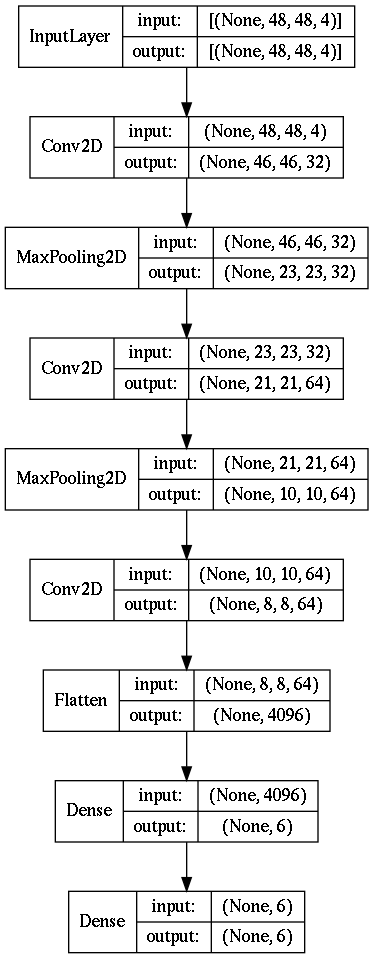

In [29]:
plot_model(model, to_file='analysis/model_cnn.png', show_shapes=True, show_layer_names=False)

In [35]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse','accuracy'])

#history = model.fit_generator(train_data_gen,epochs=50)
epochs = 10

history = model.fit(x=train_x,y=train_y,epochs=epochs,use_multiprocessing=True,verbose=1,validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 0s 534us/sample - loss: 54.4059 - mean_squared_error: 54.4059 - acc: 0.9989 - val_loss: 52.0980 - val_mean_squared_error: 52.0980 - val_acc: 1.0000
Epoch 2/10
900/900 [==============================] - 0s 254us/sample - loss: 52.8104 - mean_squared_error: 52.8104 - acc: 0.9989 - val_loss: 61.6087 - val_mean_squared_error: 61.6087 - val_acc: 1.0000
Epoch 3/10
900/900 [==============================] - 0s 251us/sample - loss: 54.5242 - mean_squared_error: 54.5242 - acc: 0.9967 - val_loss: 47.2123 - val_mean_squared_error: 47.2123 - val_acc: 1.0000
Epoch 4/10
900/900 [==============================] - 0s 249us/sample - loss: 51.1862 - mean_squared_error: 51.1862 - acc: 0.9989 - val_loss: 48.7714 - val_mean_squared_error: 48.7714 - val_acc: 1.0000
Epoch 5/10
900/900 [==============================] - 0s 255us/sample - loss: 48.0833 - mean_squared_error: 48.0833 - acc: 0.9978 - val_loss: 46.6

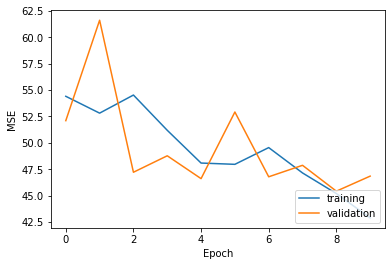

In [36]:
plt.plot(history.history['mean_squared_error'], label='training')
plt.plot(history.history['val_mean_squared_error'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
model.save(os.path.join(MODELS_DIR, f'model_cnn_val_data-{countedDetectionRows}_epochs-{epochs}.h5'))

In [ ]:
#model.predict()

for index,row in df_temp.sample(50).iterrows():
    
    ImageIdSubId = row["ImageId"]
    
    extra_inputs = [row["x1"],row["y1"],row["x2"],row["y2"]]
    temp_array = format_inputs_appended_with_image(ImageIdSubId,extra_inputs,detector_name)
    
    temp_array = np.array([temp_array])
    
    print(model.predict(temp_array))
    print(row["x"],row["y"],row["z"],row["yaw"],row["pitch"],row["roll"])
    
    break

In [ ]:
#from tensorflow.keras.initializers import glorot_uniform
#model = tf.keras.models.load_model('cnn-1.h5',custom_objects={'GlorotUniform': glorot_uniform()})